<a href="https://colab.research.google.com/github/wanyuL/ReinforcementRats2021/blob/master/RNN_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a RNN on neuropixel data by self-supervision
Here we construct a simple RNN composed of a GRU encoder and a linear decoder. It is a simple seq-to-seq model with recurrent connections.
Then we train the model using the Steizman Neuropixel data in a self-supervised way.
The goal is to check whether the low-dimentional latent features learnt by the GRU could reflect animals' behavioral states.

In [1]:
# Colab:
! git clone https://github.com/wanyuL/ReinforcementRats2021.git 
import sys 
sys.path.append('./ReinforcementRats2021')

Cloning into 'ReinforcementRats2021'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 224 (delta 78), reused 168 (delta 39), pack-reused 0
Receiving objects: 100% (224/224), 124.26 MiB | 23.70 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [2]:
import nmastandard
from rnn0 import *
from gen_fake_data import *
from load_data import *
import pickle
import nmastandard as nmas
import matplotlib.pyplot as plt
from get_active_neurons import *

# set ploting style
import seaborn as sns
sns.set(style='white',palette='colorblind',context='talk')

device=nmastandard.set_device()  # select device
nmas.set_seed(seed=7,seed_torch=True)    # set seed
# torch.use_deterministic_algorithms(True)

GPU is enabled in this notebook.
Random seed 7 has been set.


active spk shape (250, 247, 100)


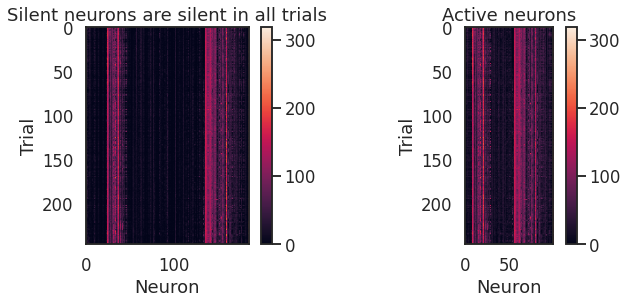

In [3]:
# load data
alldat=get_all_subject()   # run this once, takes long time
subject=18
brain_area="APN"
min_spk_per_trial=5    # 1,2,9,30
dat,NeuronInd,spk,resp=get_ind_active_neurons(alldat,subject,brain_area,min_spk_per_trial,plotopt=1)


In [4]:
# prepare for training: get training data and validation data
ntrials=spk.shape[1]
trainingData = torch.from_numpy(spk[:, :ntrials*3//5, :]).to(device).float()
train_resp=resp[:ntrials*3//5]

valData = torch.from_numpy(spk[:, ntrials*3//5:ntrials*4//5, :]).to(device).float()
val_resp=resp[ntrials*3//5:ntrials*4//5]


testData = torch.from_numpy(spk[:, ntrials*4//5:, :]).to(device).float()
testresp = resp[ntrials*4//5:]

trainingData.shape,valData.shape,testData.shape

(torch.Size([250, 148, 100]),
 torch.Size([250, 49, 100]),
 torch.Size([250, 50, 100]))

In [7]:
# initialize the ANN
ncomp=5
import nmastandard as nmas
nmas.set_seed(seed=6,seed_torch=True)
# we initialize the neural network
net = rnn0(ncomp, trainingData.shape[-1], trainingData.shape[-1], dropout=0 ,bidi = False).to(device)
# special thing:  we initialize the biases of the last layer in the neural network
# we set them as the mean firing rates of the neurons.
# this should make the initial predictions close to the mean, because the latents don't contribute much
net.fc.bias.data[:] = trainingData.mean((0,1))
# # initialize other weights; this will affect loss! 
# net.fc.weight.data.data.normal_(0,.02)
# net.rnn.weight_hh_l0.data.normal_(0,.02)
# net.rnn.weight_ih_l0.data.normal_(0,.02)
# net.rnn.bias_hh_l0.data.normal_(0,.02)
# net.rnn.bias_ih_l0.data.normal_(0,.02)

Random seed 6 has been set.


Random seed 8 has been set.
iteration 0, train_loss 0.2661 , val_loss 0.2491
iteration 50, train_loss 0.1961 , val_loss 0.1851
iteration 100, train_loss 0.1901 , val_loss 0.1793
iteration 150, train_loss 0.1828 , val_loss 0.1721


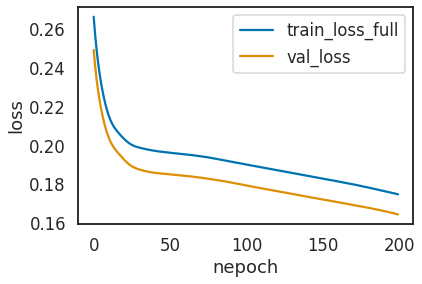

In [8]:
# train the rnn!
nmas.set_seed(seed=8,seed_torch=True)
# bs=trainingData.shape[2]
bs=20
_,_,train_latv,val_latv = rnn0.train(net,trainingData,trainingData,200,0.005,device,bs, nn.MSELoss(), testData,testData)
# might not expect the model to generalize well, as the adjacency matrices might 
# differ between different neuron subpopulations

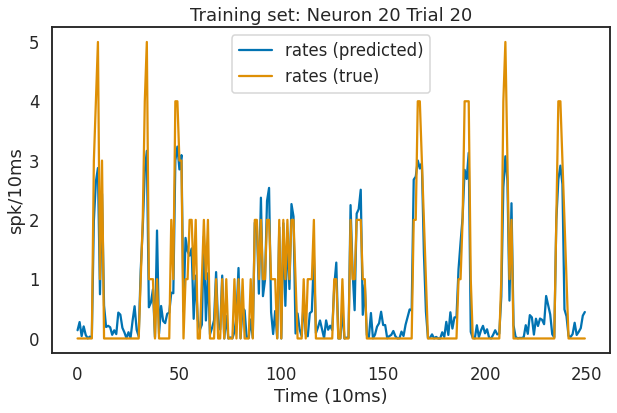

In [9]:
# visualize the performance of the rnn model
netinput=testData
prd,_=net(netinput)  
rpred = prd.detach().cpu().numpy()

ntrial = 40

# # Plot for Test Data
# plt.figure(figsize=(10, 6))
# plt.plot(rpred[:,ntrial, nn], label='rates (predicted)')
# plt.plot(testData[:, ntrial, nn].detach().numpy(), label='rates (data)')
# plt.legend()
# plt.title(f'Validation set: Neuron {nn} Trial {ntrial}')
# plt.show()

# Plot for Training Data
netinput=trainingData
prd,_=net(netinput)  
rpred = prd.detach().cpu().numpy()
NN = 20
ntrial = 20
plt.figure(figsize=(10, 6))

plt.plot(rpred[:,ntrial, NN], label='rates (predicted)')
plt.plot( trainingData[:, ntrial, NN].detach().cpu().numpy(), label='rates (true)')

plt.legend()
plt.title(f'Training set: Neuron {NN} Trial {ntrial}')

plt.xlabel('Time (10ms)')
plt.ylabel('spk/10ms')
plt.show()

-1.0
0.0
1.0


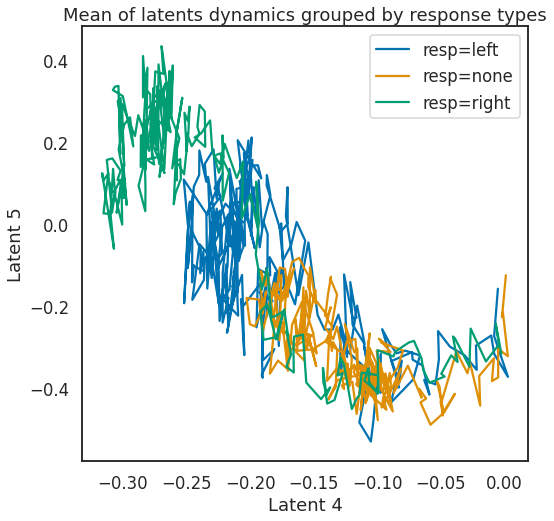

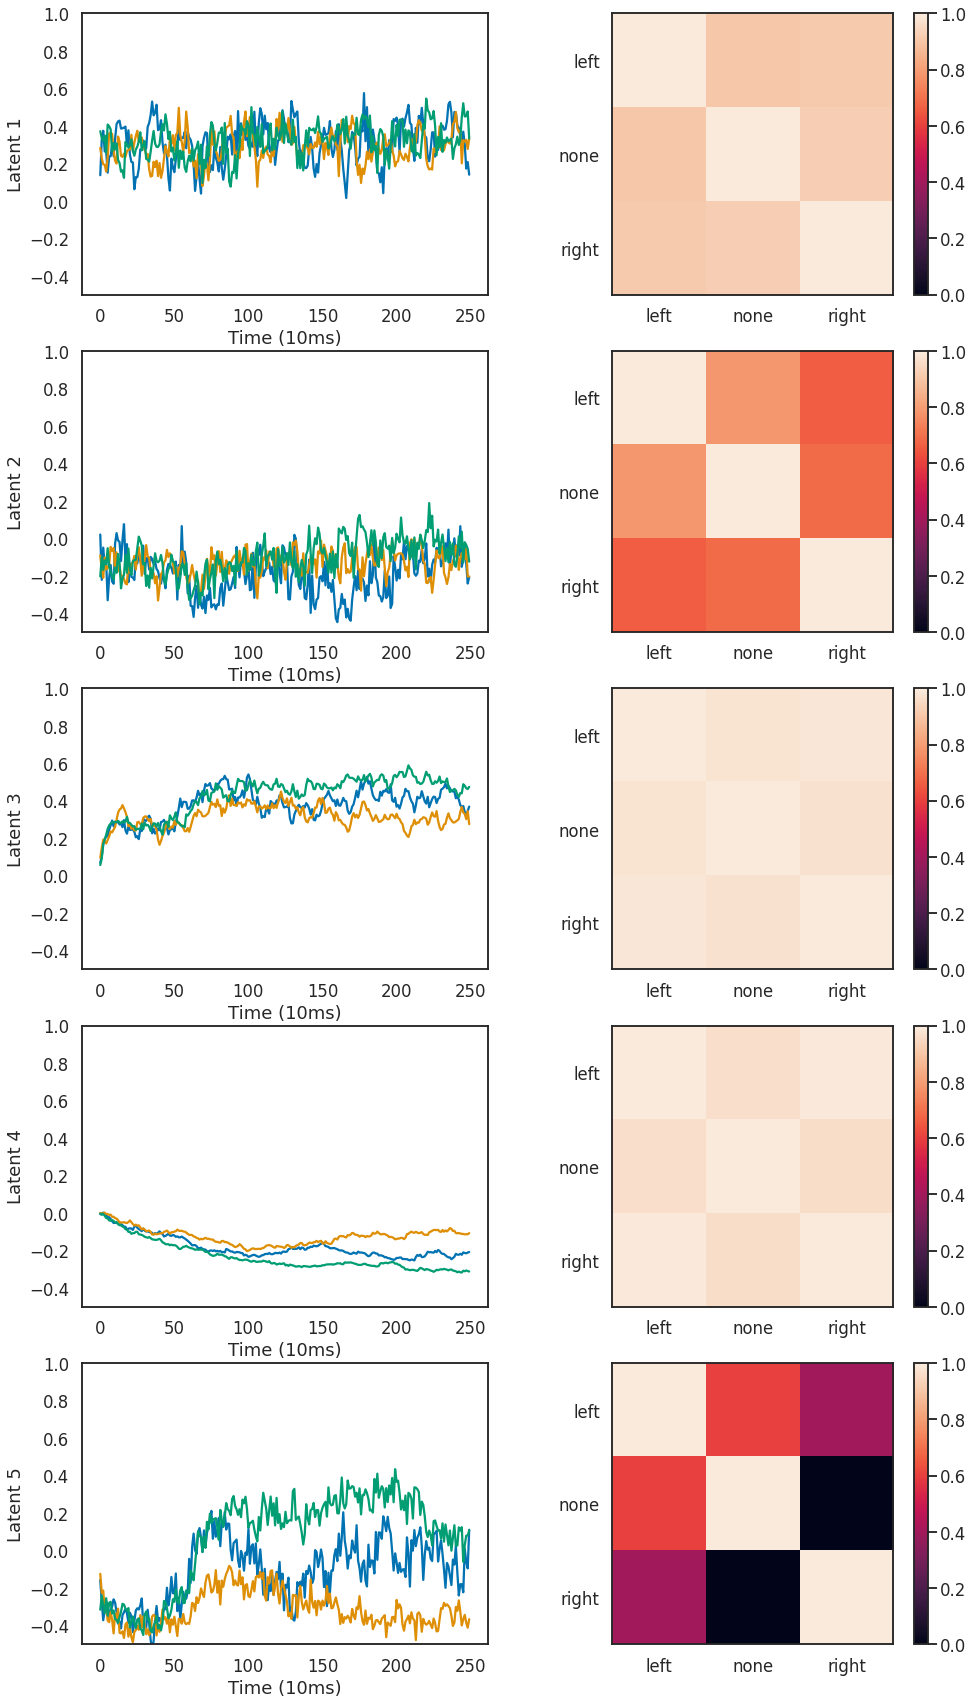

In [10]:
## Check latent variable dynamics and RSM (representational similarity matrix)
input=torch.tensor(spk,device=device)
input=input.permute(2,1,0)
# _,lat=net.rnn(input,ncomp)
latvd=train_latv.detach().cpu().numpy()
latvd.shape
ncomp=5
plt.figure(figsize=(8,8))
# 2d latents version
for i, resp_type in enumerate(np.unique(train_resp)):
  print(resp_type)
  trial_ind=train_resp==resp_type
  plt.plot(latvd[:,trial_ind,3].mean(axis=1),latvd[:,trial_ind,4].mean(axis=1),label= resp_type)
plt.legend(('resp=left','resp=none','resp=right'))
plt.title('Mean of latents dynamics grouped by response types')
plt.xlabel('Latent 4')
plt.ylabel('Latent 5')


# fig, axs = plt.subplots(ncomp, figsize=(8, 2*ncomp))

plt.figure(figsize=(16, 6*ncomp))
latv3=torch.zeros((3,250),device=device)
for j in range(ncomp):
  plt.subplot(ncomp,2,j*2+1)
  for i, resp_type in enumerate(np.unique(train_resp)):
    
    # print(resp_type)
    trial_ind=train_resp==resp_type
    plt.plot(latvd[:,trial_ind,j].mean(axis=1),label= resp_type)
    latv3[i,:]=torch.tensor(latvd[:,trial_ind,j].mean(axis=1))
  rsm = torch.nn.functional.cosine_similarity(
      latv3.reshape(1, 3, 250),
      latv3.reshape(3, 1, 250),
      dim=2
      )
  plt.xlabel('Time (10ms)')
  plt.ylabel('Latent %i' %(j+1))
  plt.ylim(-.5,1)
  plt.subplot(ncomp,2,j*2+2)
  plt.imshow(rsm.detach().cpu().numpy())
  plt.clim(0,1)
  plt.xticks([0,1,2],['left','none','right'])
  plt.yticks([0,1,2],['left','none','right'])
  # plt.gca().set_xticks()
  plt.colorbar()


-1.0
0.0
1.0


Text(0, 0.5, 'Latent 5')

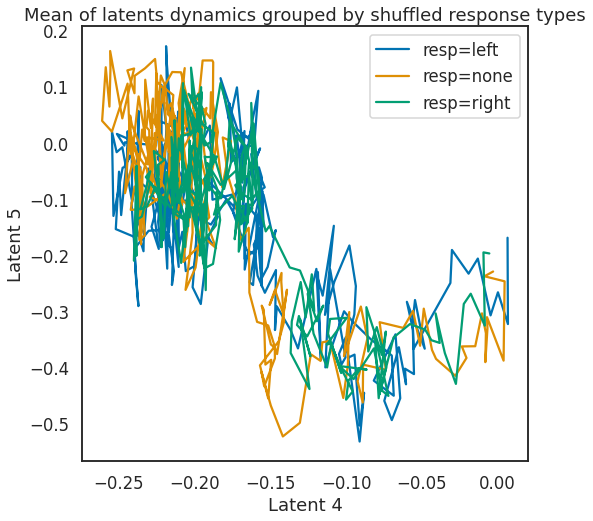

In [15]:
# shuffle the indx 
plt.figure(figsize=(8,8))
shuffle_train_resp=train_resp
latvd2=latvd
np.random.shuffle(shuffle_train_resp)
for i, resp_type in enumerate(np.unique(shuffle_train_resp)):
  print(resp_type)
  trial_ind=shuffle_train_resp==resp_type
  plt.plot(latvd2[:,trial_ind,3].mean(axis=1),latvd2[:,trial_ind,4].mean(axis=1),label= resp_type)
plt.legend(('resp=left','resp=none','resp=right'))
plt.title('Mean of latents dynamics grouped by shuffled response types')
plt.xlabel('Latent 4')
plt.ylabel('Latent 5')

# Check reconstruction errors (MSE) of PCA, GRU, and GRU based Autoencoder



iteration 0, train_loss 0.2779 , val_loss 0.2717
iteration 50, train_loss 0.2070 , val_loss 0.2013
iteration 100, train_loss 0.2000 , val_loss 0.1946
iteration 150, train_loss 0.1974 , val_loss 0.1922


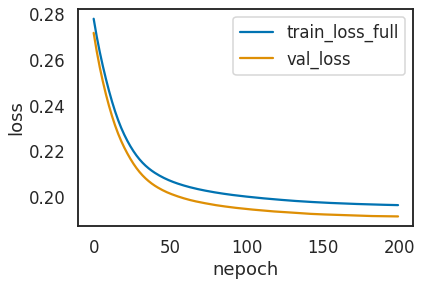

iteration 0, train_loss 0.2769 , val_loss 0.2707
iteration 50, train_loss 0.2014 , val_loss 0.1957
iteration 100, train_loss 0.1969 , val_loss 0.1916
iteration 150, train_loss 0.1954 , val_loss 0.1903


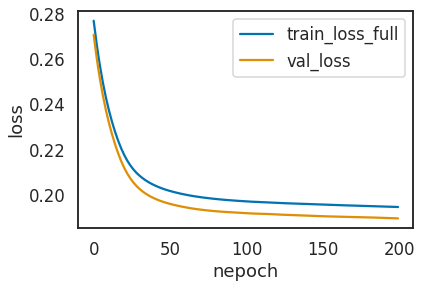

iteration 0, train_loss 0.2678 , val_loss 0.2635
iteration 50, train_loss 0.1968 , val_loss 0.1915
iteration 100, train_loss 0.1903 , val_loss 0.1856
iteration 150, train_loss 0.1851 , val_loss 0.1807


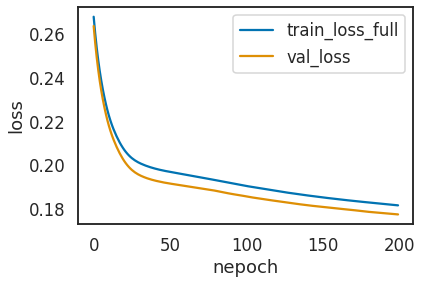

iteration 0, train_loss 0.2330 , val_loss 0.2283
iteration 50, train_loss 0.1889 , val_loss 0.1839
iteration 100, train_loss 0.1662 , val_loss 0.1625
iteration 150, train_loss 0.1500 , val_loss 0.1470


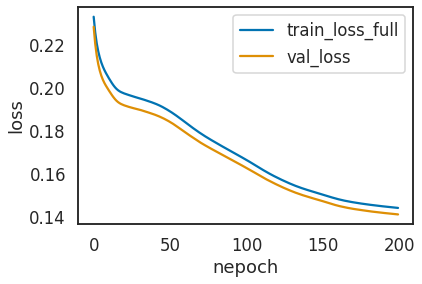

iteration 0, train_loss 0.2262 , val_loss 0.2215
iteration 50, train_loss 0.1501 , val_loss 0.1469
iteration 100, train_loss 0.1193 , val_loss 0.1171
iteration 150, train_loss 0.1123 , val_loss 0.1102


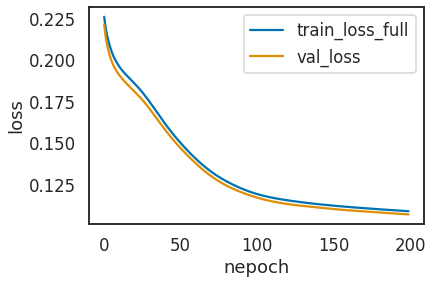

iteration 0, train_loss 0.2075 , val_loss 0.2018
iteration 50, train_loss 0.0849 , val_loss 0.0837
iteration 100, train_loss 0.0704 , val_loss 0.0698
iteration 150, train_loss 0.0644 , val_loss 0.0639


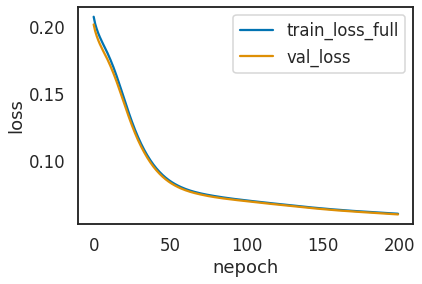

Text(0, 0.5, ' MSE validation loss')

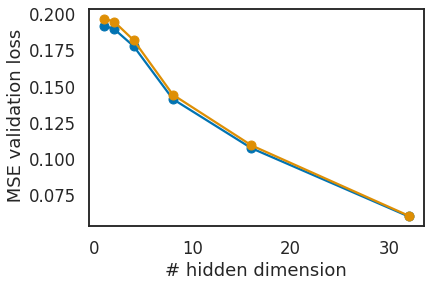

In [18]:
# the width of the network matters. 
ncomprange = np.array([1,2,4,8,16,32])   #,3,5, 10, 20,30
vallosst=np.zeros(len(ncomprange))
testlosst=np.zeros(len(ncomprange))
for i, ncomp in enumerate(ncomprange):
  # validation loss as a function of the number of hidden units
  net = rnn0(ncomp, trainingData.shape[-1], trainingData.shape[-1], dropout=0 ,bidi = False).to(device)
  # special thing:  we initialize the biases of the last layer in the neural network
  # we set them as the mean firing rates of the neurons.
  # this should make the initial predictions close to the mean, because the latents don't contribute much
  net.fc.bias.data[:] = trainingData.mean((0,1))
  bs=20  # batchsize
  testloss,valloss,_,val_latv = rnn0.train(net,trainingData,trainingData,200,0.005,device,bs, nn.MSELoss(), valData,valData)
  vallosst[i]=valloss[-1]
  testlosst[i]=testloss[-1]
  file = open(f"simple_gru_val_latent={ncomp}.pkl",'wb')
  pickle.dump(val_latv.detach().cpu().numpy(),file)
plt.plot(ncomprange,vallosst,'-o',label='val loss')
plt.plot(ncomprange,testlosst,'-o',label='test loss')

plt.xlabel('# hidden dimension')
plt.ylabel(' MSE validation loss')

250 148 100 250 49 100
(37000, 100)
(12250, 100)


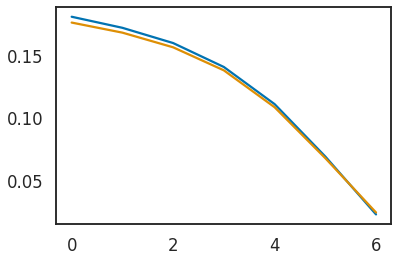

In [62]:
##generating PCA for reconstruction error 

#print(np.shape(trainingData))
from sklearn.decomposition import PCA

# get it back into a numpy array 
trainingData_pca = trainingData.cpu().numpy()
testData_pca = valData.cpu().numpy()    # test here is val

##dimensions should be  time, trials, neurons
a,b,c = np.shape(trainingData_pca)#
trainingData_pca2d = trainingData_pca.reshape(-1, c)

d,e,f = np.shape(testData_pca)#
testData_pca2d = testData_pca.reshape(-1, f)
#run PCA previously ran on training seta

print(a,b,c,d,e,f)


print(np.shape(trainingData_pca2d))
print(np.shape(testData_pca2d))

pca_training_mse_list = []
pca_test_mse_list = []
variance_explained_list = []
count = 1
params = [1,2,4,8,16,32,64] # your component list here


for i in params:
  pca_fit = PCA(n_components = i).fit(trainingData_pca2d)
  # plt.plot(np.cumsum(pca_fit.explained_variance_ratio_))
  # plt.title(f'PCA Variance Explained Ratio')  

  ##reconstructing the training data using specifed parameters
  training_transformed = pca_fit.transform(trainingData_pca2d)
  training_inv_transformed = pca_fit.inverse_transform(training_transformed)
  training_mse = np.mean((trainingData_pca2d - training_inv_transformed) ** 2)


  #test set PCA
  test_transformed = pca_fit.transform(testData_pca2d)
  test_inv_transformed = pca_fit.inverse_transform(test_transformed)
  test_mse = np.mean((testData_pca2d - test_inv_transformed) ** 2)

  pcalatent = np.reshape(test_transformed, (250, -1, i))
  file = open(f"pca_val_latent={i}.pkl",'wb')
  pickle.dump(pcalatent,file)
  

  pca_training_mse_list.append(training_mse)
  pca_test_mse_list.append(test_mse)
  variance_explained_list.append((np.cumsum(pca_fit.explained_variance_ratio_)))
  count = count + 1
plt.plot(pca_training_mse_list)
plt.plot(pca_test_mse_list)

In [ ]:
# load loss of gru-based autoencoder
# use the files in GRU_AE_loss folder!! (make sure those files are in your working directory)
val_aernn=[]
for i in [1,2,4,8,16,32,64]:
    file = open(f"loss_val_GRU_latent={i}.pkl",'rb')
    ld = pickle.load(file)
    val_aernn.append(ld)

plt.plot(val_aernn)

train_aernn=[]
for i in [1,2,4,8,16,32,64]:
    file = open(f"loss_training_GRU_latent={i}.pkl",'rb')
    ld = pickle.load(file)
    train_aernn.append(ld)

plt.plot(train_aernn)

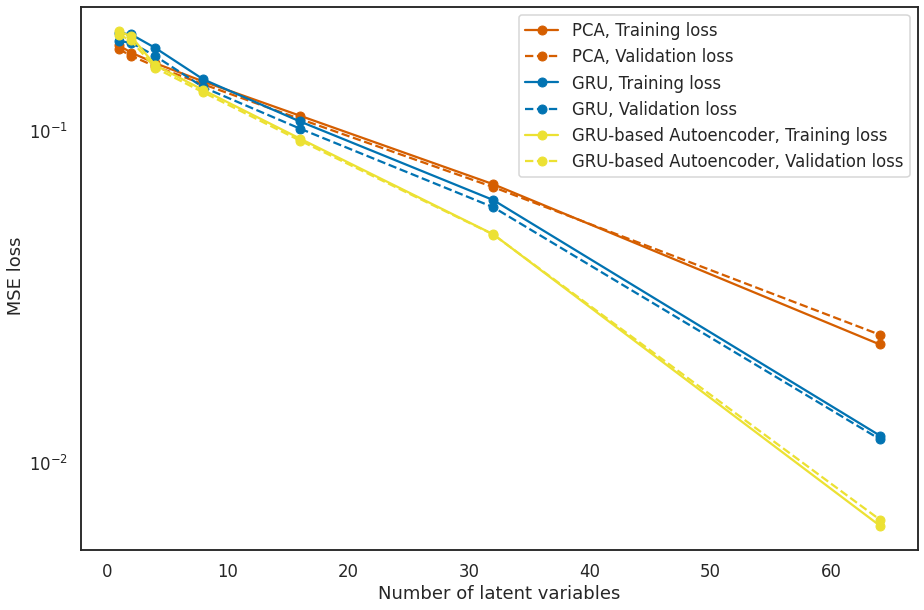

In [43]:
# plot MSE error for all

plt.figure(figsize=(1,10))

plt.semilogy(ncomprange,pca_training_mse_list,'r-o',label='PCA, Training loss')
plt.semilogy(ncomprange,pca_test_mse_list,'r--o',label='PCA, Validation loss')


plt.semilogy(ncomprange,testlosst,'b-o',label='GRU, Training loss')
plt.semilogy(ncomprange,vallosst,'b--o',label='GRU, Validation loss')




plt.semilogy(ncomprange,train_aernn,'y-o',label='GRU-based Autoencoder, Training loss')
plt.semilogy(ncomprange,val_aernn,'y--o',label='GRU-based Autoencoder, Validation loss')

plt.xlabel('Number of latent variables')
plt.ylabel(' MSE loss')
plt.legend()


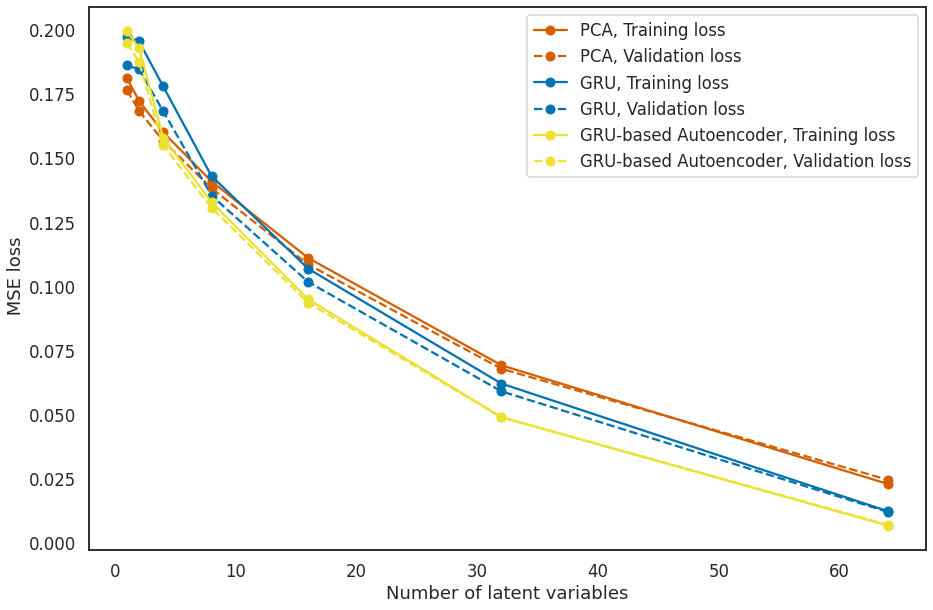

In [54]:
# plot all

plt.figure(figsize=(15,10))

plt.plot(ncomprange,pca_training_mse_list,'r-o',label='PCA, Training loss')
plt.plot(ncomprange,pca_test_mse_list,'r--o',label='PCA, Validation loss')


plt.plot(ncomprange,testlosst,'b-o',label='GRU, Training loss')
plt.plot(ncomprange,vallosst,'b--o',label='GRU, Validation loss')




plt.plot(ncomprange,train_aernn,'y-o',label='GRU-based Autoencoder, Training loss')
plt.plot(ncomprange,val_aernn,'y--o',label='GRU-based Autoencoder, Validation loss')

plt.xlabel('Number of latent variables')
plt.ylabel(' MSE loss')
plt.legend()
